In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
E = [400, 600, 500] # suppliers capacity
D = [300, 400, 500, 350] # plants capacity
W = [150, 150, 350, 500] # DCs capacity
d = [200, 150, 200, 250, 100] # customers demand

In [3]:
g = [1150, 1200, 900, 1250] # plants operation $
v = [900, 1050, 1300, 1100] # DCs operation $

In [4]:
# suppliers-plants transportation + purchasing $
t = np.array([
    [6, 5, 6, 7],
    [4, 2, 7, 6],
    [4, 3, 7, 4]
])

In [5]:
# plants-DCs transportation $
a = np.array([
    [4, 4, 2, 1],
    [3, 2, 2, 4],
    [4, 6, 5, 3],
    [8, 3, 7, 2]
])

In [6]:
# DCs-customers transportation $
c = np.array([
    [7, 4, 7, 7, 6],
    [9, 2, 3, 8, 9],
    [6, 7, 3, 8, 3],
    [3, 7, 9, 4, 9]
])

In [7]:
ch = [3, 8, 5, 2, 1, 7, 4, 6] # chromosome

In [8]:
from utils import transportation_tree
q, z = transportation_tree(    d[:], W[:], c[:], ch[4:])
f, p = transportation_tree(q.sum(1), D[:], a[:], ch[:4], split_delivery=True)
b, s = transportation_tree(f.sum(1), E[:], t[:], ch[:4], split_delivery=True, priority='right')

Assign 150 from Plant 2 to Customer 2
Assign 200 from Plant 4 to Customer 1
Assign 250 from Plant 4 to Customer 4
Assign 200 from Plant 3 to Customer 3
Assign 100 from Plant 3 to Customer 5
Assign 150.0 from Plant 2 to Customer 2
Assign 250.0 from Plant 2 to Customer 3
Assign 450.0 from Plant 3 to Customer 4
Assign 50.0 from Plant 3 to Customer 3
Assign 400.0 from Plant 2 to Customer 2
Assign 400.0 from Plant 1 to Customer 3
Assign 100.0 from Plant 2 to Customer 3


In [15]:
q, z, f, p, b, s = decode_chromosome(ch, E, D, W, d, t, a, c)

In [17]:
from utils import evaluate_solution
evaluate_solution(b, t, p, g, f, a, z, v, q, c)

14650.0

In [27]:
from utils import chromosome_fitness
chromosome_fitness(ch, E, D, W, d, t, a, c, g, v)

14650.0

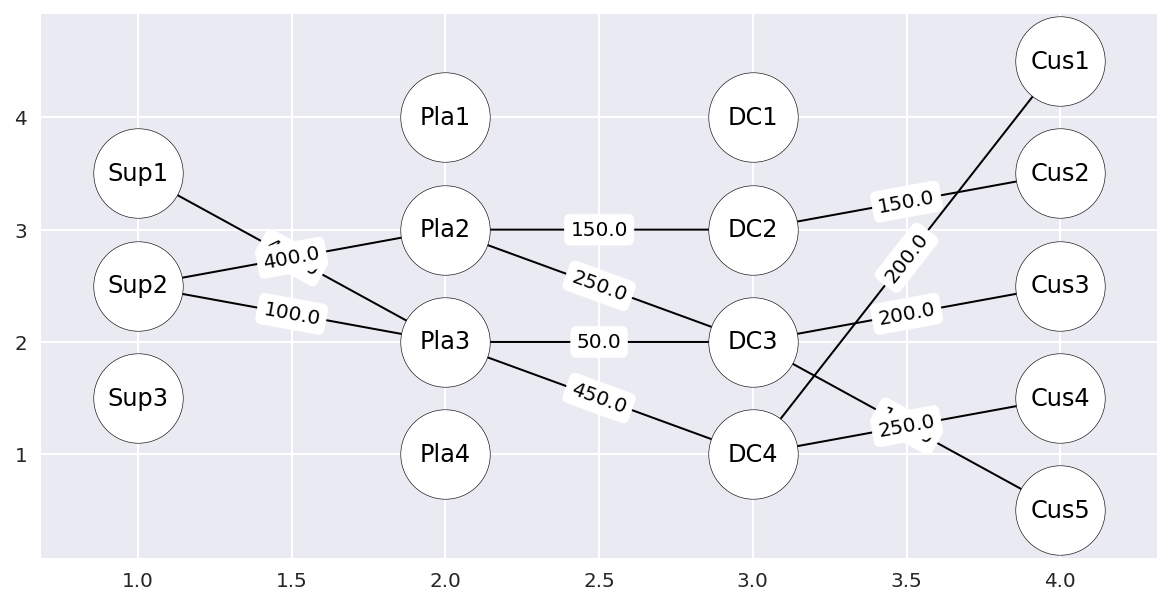

In [18]:
from utils import plot_graph
plot_graph(b, f, q)

## Genetic Algorithm

In [19]:
import random
from deap import creator, base, tools, algorithms

In [20]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', list, fitness=creator.FitnessMin)

In [22]:
N_NODES = len(D) + len(W) # num plants + num DCs

In [23]:
toolbox = base.Toolbox()

toolbox.register('permutation', random.sample, range(N_NODES), N_NODES)
toolbox.register('individual', tools.initIterate, creator.Individual,
                 toolbox.permutation)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

In [37]:
ga_fitness = lambda x: (partial(chromosome_fitness, E=E, 
                            D=D, W=W, d=d, t=t, a=a, c=c, g=g, v=v)(x),)

In [ ]:
print(W, d, q, v, demand_limit)

In [38]:
from functools import partial

toolbox.register('evaluate', ga_fitness)
toolbox.register('mate', tools.cxPartialyMatched)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb=2.0/N_NODES)
toolbox.register('select', tools.selTournament, tournsize=3)

In [39]:
pop = toolbox.population(n=20)
hof = tools.HallOfFame(5)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('Avg', np.mean)
stats.register('Std', np.std)
stats.register('Min', np.min)
stats.register('Max', np.max)

In [40]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=5, 
                    stats=stats, halloffame=hof, verbose=True)

gen	nevals	Avg    	Std    	Min  	Max  
0  	20    	16782.5	1414.94	14400	19900
1  	14    	15882.5	1452.35	14400	19150
2  	11    	14717.5	644.064	14400	17400
3  	11    	14520  	299.75 	14350	15700
4  	17    	14487.5	301.196	14350	15700
5  	14    	14570  	593.801	14350	16350


In [41]:
hof.items

[[4, 7, 3, 5, 0, 6, 2, 1],
 [1, 6, 0, 5, 3, 7, 4, 2],
 [5, 6, 0, 3, 1, 7, 4, 2],
 [5, 6, 0, 1, 3, 7, 4, 2],
 [5, 6, 3, 1, 2, 7, 4, 0]]

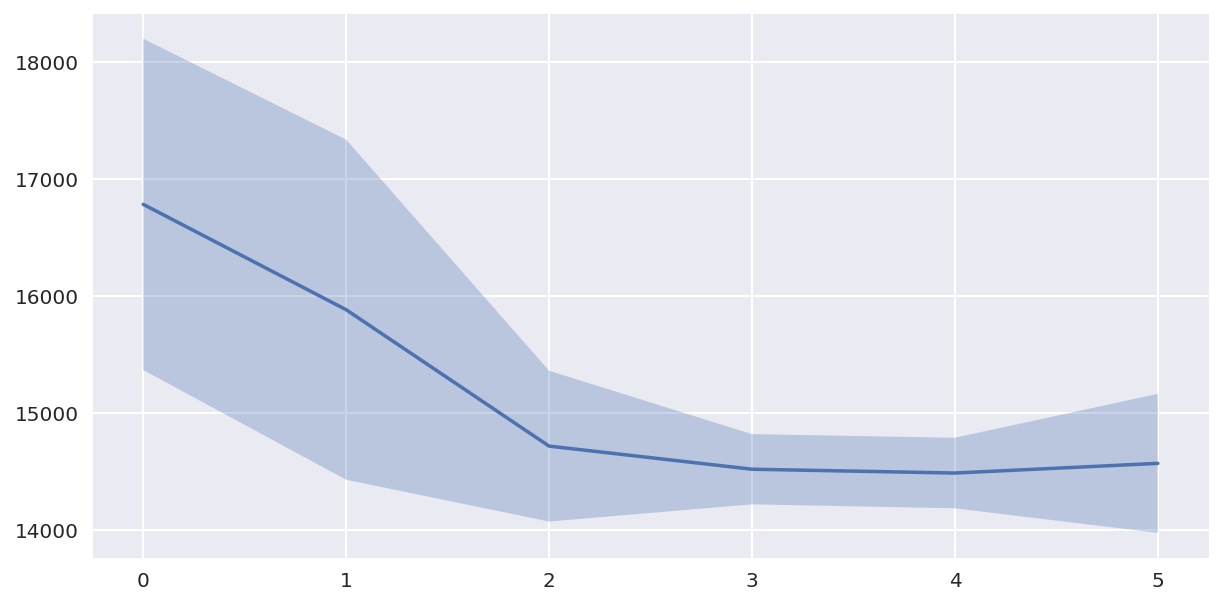

In [48]:
from utils import plot_log
plot_log(log)

## Refactor

In [55]:
from utils import init_genetic_algorithm

toolbox, stats = init_genetic_algorithm(chromosome_fitness, 
                            E, D, W, d, t, a, c, g, v)
pop = toolbox.population(n=20)
hof = tools.HallOfFame(5)

In [56]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=5, 
                    stats=stats, halloffame=hof, verbose=True)

gen	nevals	Avg    	Std    	Min  	Max  
0  	20    	15262.5	938.866	14350	17750
1  	10    	14995  	996.481	14350	17800
2  	11    	14720  	711.407	14350	17750
3  	7     	14477.5	161.613	14350	14950
4  	13    	14540  	544.197	14350	16850
5  	14    	14457.5	309.546	14350	15750


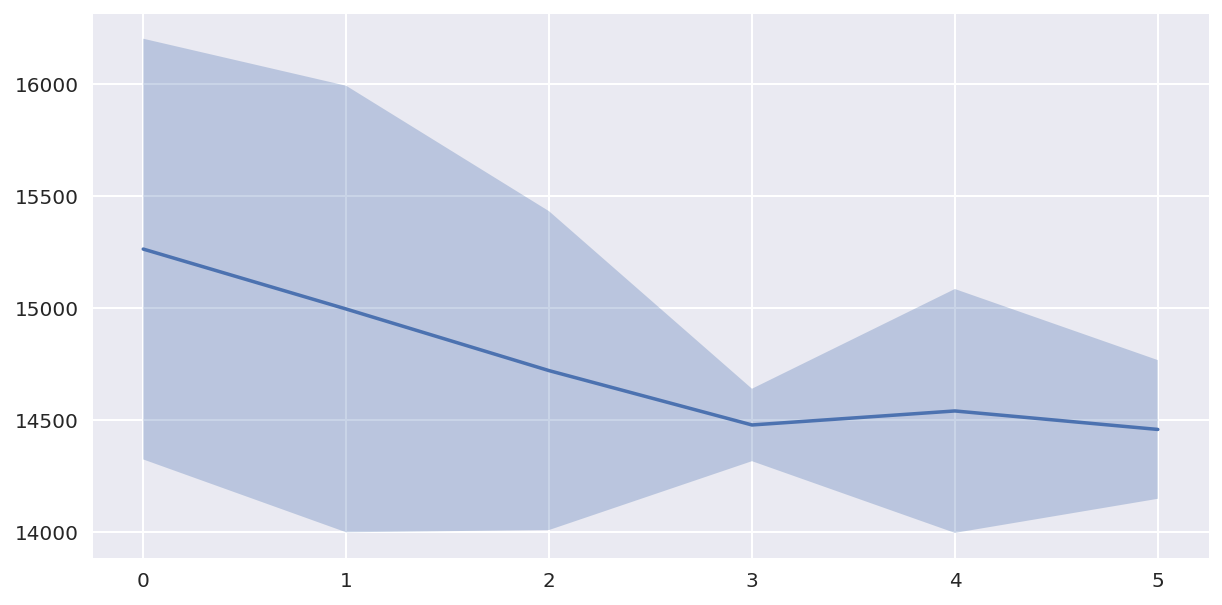

In [57]:
plot_log(log)

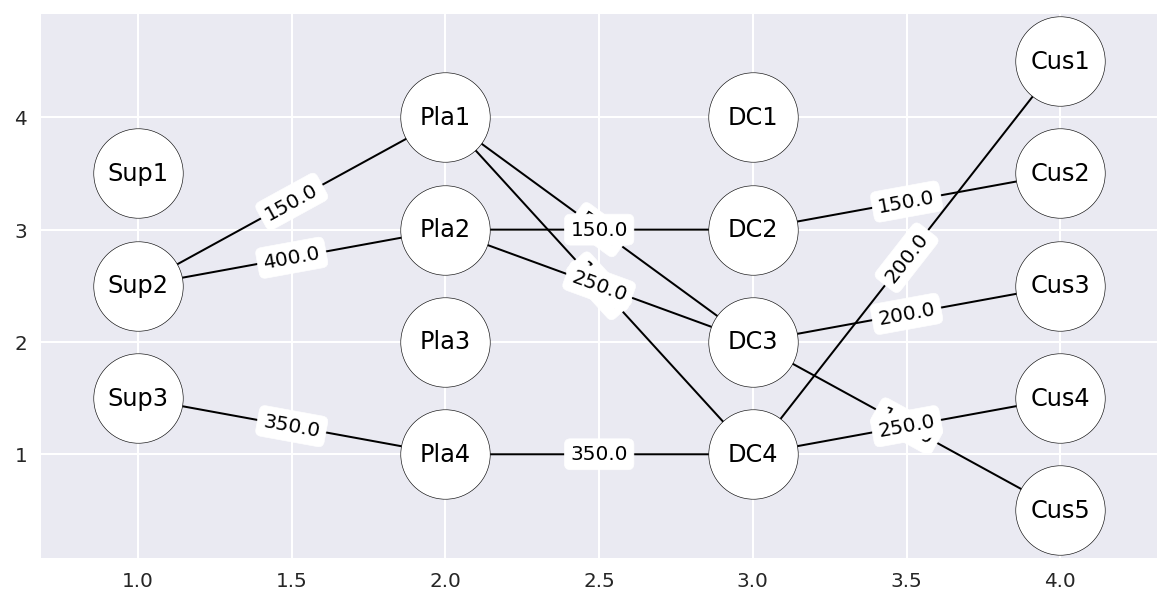

In [61]:
q, z, f, p, b, s = decode_chromosome(hof.items[0], E, D, W, d, t, a, c)
plot_graph(b, f, q)

In [63]:
# CPLEX optimal solution objective: 14,200 
b = np.array([
    [0, 0, 0, 0],
    [0, 400, 0, 0],
    [300, 0, 0, 200]
])
f = np.array([
    [0, 0, 0, 300],
    [0, 100, 300, 0],
    [0, 0, 0, 0],
    [0, 50, 0, 150]
])
q = np.array([
    [0, 0, 0, 0, 0],
    [0, 150, 0, 0, 0],
    [0, 0, 200, 0, 100],
    [200, 0, 0, 250, 0]
])

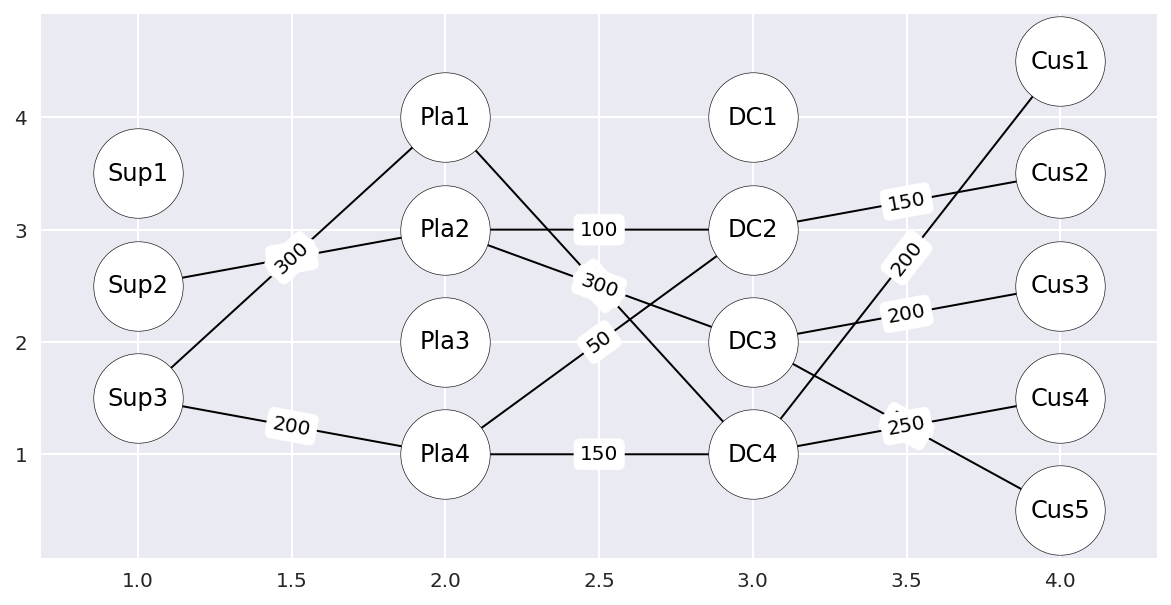

In [64]:
plot_graph(b, f, q)

In [66]:
toolbox, stats = init_genetic_algorithm(chromosome_fitness, 
                            E, D, W, d, t, a, c, g, v)
pop = toolbox.population(n=300)
hof = tools.HallOfFame(5)

In [67]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, 
                    ngen=100, stats=stats, halloffame=hof, verbose=True)

gen	nevals	Avg  	Std    	Min  	Max  
0  	300   	16230	1488.65	14350	19900
1  	182   	15477.3	1200.72	14350	19900
2  	169   	15025.3	1000.17	14350	19900
3  	195   	15018  	1032.7 	14350	19050
4  	173   	14713.8	773.122	14350	19900
5  	189   	14588.7	558.828	14350	17800
6  	170   	14617.5	688.986	14350	18650
7  	172   	14645  	753.685	14350	17800
8  	183   	14610.8	746.475	14350	19800
9  	183   	14552.3	606.571	14350	18500
10 	166   	14612.2	715.898	14350	18550
11 	179   	14554.3	627.48 	14350	19150
12 	176   	14587.5	637.771	14350	18650
13 	186   	14620.5	695.417	14350	19000
14 	184   	14633.5	784.264	14350	19000
15 	185   	14609.3	699.318	14350	18950
16 	167   	14591.5	704.488	14350	19900
17 	191   	14600.5	711.881	14350	18550
18 	174   	14561.5	668.588	14350	18950
19 	185   	14602.8	759.956	14350	18500
20 	188   	14558.7	626.837	14350	18650
21 	163   	14523.2	631.602	14350	18550
22 	177   	14545  	620.343	14350	19150
23 	171   	14526.8	530.696	14350	17850
24 	170   	14534.3	565.468	14

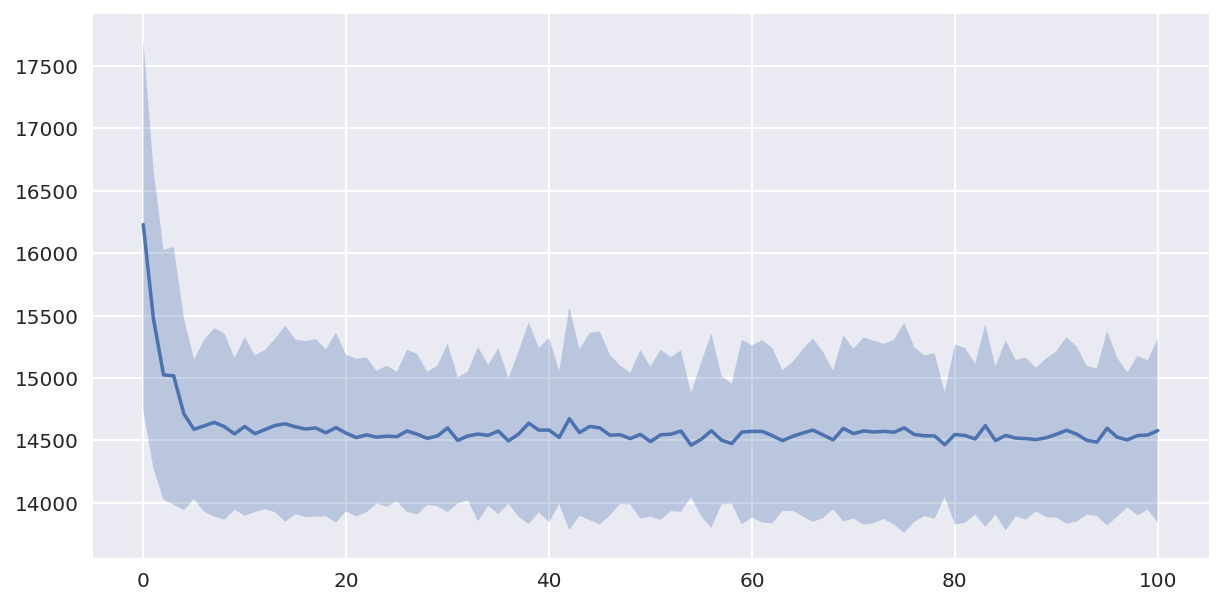

In [68]:
plot_log(log)

In [71]:
ga_fitness(hof.items[0])

(14350.0,)